## Importing libraries and utility functions

In [1]:
from utils import *

## Data processing

In [2]:
images, labels = load_galaxy10sdss()
labels = labels.astype(np.float32)
images = np.array(images)
images = images.astype(np.float32)
images = images/255 
print(images.shape)
print(labels.shape)

C:\Users\abhim\.astroNN\datasets\Galaxy10.h5 was found!
(21785, 69, 69, 3)
(21785,)


In [3]:
images, labels, images_removed, labels_removed = remove_specific_class(images, labels, 5)
images_removed = np.array(images_removed).squeeze()
labels_removed = np.array(labels_removed).squeeze()
print(images.shape)
print(labels.shape)
print(images_removed.shape)
print(labels_removed.shape)
print(np.unique(labels_removed))

labels = convert_to_categorical(labels)

print(labels.shape)


(21768, 69, 69, 3)
(21768,)
(17, 69, 69, 3)
(17,)
[5.]
(21768, 9)


In [4]:
X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(
    images,
    labels,
    test_size = 0.30,
    random_state=42
)
X_test, X_val, y_test, y_val = train_test_split(
    X_test_and_val, 
    y_test_and_val, 
    test_size=0.5, 
    random_state=42
)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(15237, 69, 69, 3)
(15237, 9)
(3266, 69, 69, 3)
(3266, 9)
(3265, 69, 69, 3)
(3265, 9)


In [5]:
for mode in ['train', 'val', 'test']:
    create_hdf5_file(
        images = eval(f'X_{mode}'),
        labels = eval(f'y_{mode}'),
        mode = mode
    )

## Set seed for sampling of weights in Bayesian network

In [5]:
tf.random.set_seed(0)
divergence_fn = lambda q, p, _ : tfd.kl_divergence(q, p) / X_train.shape[0]

## Frequentist CNN

In [6]:
frequentist_model = Sequential()
frequentist_model.add(Conv2D(32, kernel_size=(3,3),activation='relu',input_shape=(69,69,3)))
frequentist_model.add(Conv2D(64, (3, 3), activation='relu'))
frequentist_model.add(MaxPooling2D(pool_size=(2, 2)))
frequentist_model.add(Conv2D(64, (3, 3), activation='relu'))
frequentist_model.add(MaxPooling2D(pool_size=(2, 2)))
frequentist_model.add(Conv2D(64, (3, 3), activation='relu'))
frequentist_model.add(MaxPooling2D(pool_size=(2, 2)))
frequentist_model.add(Conv2D(64, (3, 3), activation='relu'))
frequentist_model.add(MaxPooling2D(pool_size=(2, 2)))
frequentist_model.add(Dropout(0.2))
frequentist_model.add(Flatten())
frequentist_model.add(Dense(64, activation='relu'))
frequentist_model.add(Dropout(0.2))
frequentist_model.add(Dense(32, activation='relu'))
frequentist_model.add(Dropout(0.2))
frequentist_model.add(Dense(9, activation='softmax'))
frequentist_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 67, 67, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 65, 65, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0

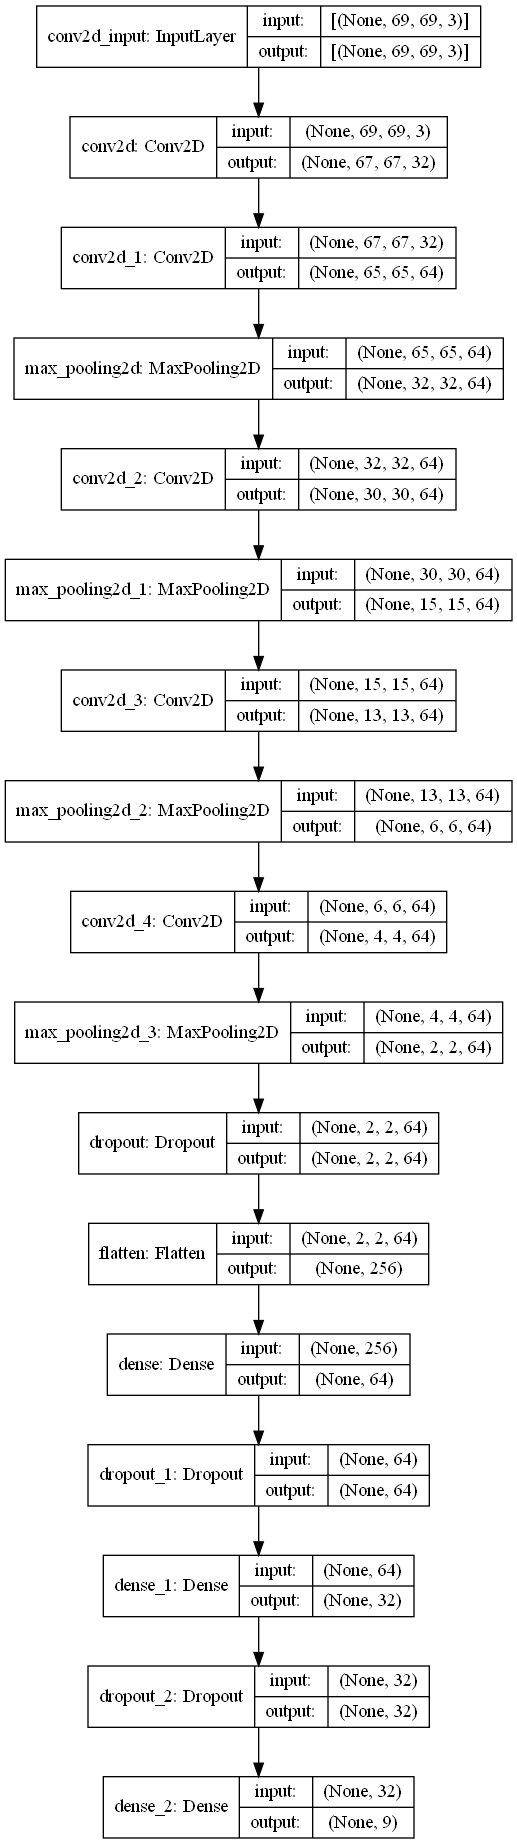

In [7]:
tf.keras.utils.plot_model(frequentist_model, to_file="frequentist.png", show_shapes=True)

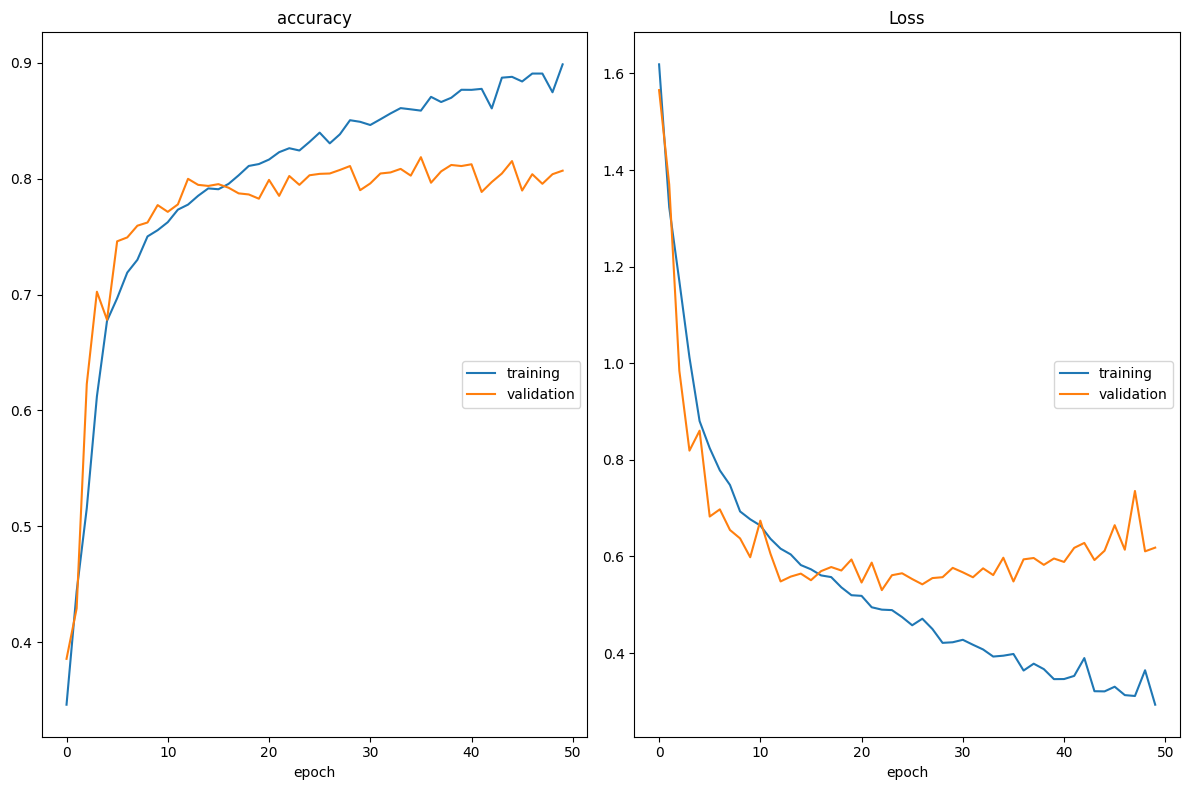

accuracy
	training         	 (min:    0.346, max:    0.898, cur:    0.898)
	validation       	 (min:    0.386, max:    0.818, cur:    0.807)
Loss
	training         	 (min:    0.293, max:    1.619, cur:    0.293)
	validation       	 (min:    0.530, max:    1.565, cur:    0.618)


In [10]:
ckpt_frequentist = tf.keras.callbacks.ModelCheckpoint(
    weights_dir['frequentist'],
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    save_freq='epoch'
)
frequentist_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
frequentist_model.fit(
    X_train,
    y_train,
    epochs= epochs,
    batch_size= batch_size,
    validation_data=(X_val, y_val),
    callbacks=[ckpt_frequentist, PlotLossesKeras()]
)

## Bayesian CNN

In [7]:
bayesian_model_scratch = Sequential()
bayesian_model_scratch.add(Conv2D(32, kernel_size=(3,3),activation='relu',input_shape=(69,69,3)))
bayesian_model_scratch.add(Conv2D(64, (3, 3), activation='relu'))
bayesian_model_scratch.add(MaxPooling2D(pool_size=(2, 2)))
bayesian_model_scratch.add(Conv2D(64, (3, 3), activation='relu'))
bayesian_model_scratch.add(MaxPooling2D(pool_size=(2, 2)))
bayesian_model_scratch.add(Conv2D(64, (3, 3), activation='relu'))
bayesian_model_scratch.add(MaxPooling2D(pool_size=(2, 2)))
bayesian_model_scratch.add(Conv2D(64, (3, 3), activation='relu'))
bayesian_model_scratch.add(MaxPooling2D(pool_size=(2, 2)))
bayesian_model_scratch.add(Dropout(0.25))
bayesian_model_scratch.add(Flatten())
bayesian_model_scratch.add(Dense(128, activation='relu'))
bayesian_model_scratch.add(Dropout(0.25))
bayesian_model_scratch.add(Dense(64, activation='relu'))
bayesian_model_scratch.add(Dropout(0.25))
bayesian_model_scratch.add(Dense(32, activation='relu'))
bayesian_model_scratch.add(Dropout(0.25))
bayesian_model_scratch.add(
    tfpl.DenseFlipout(
                 units = 9, activation = tf.nn.softmax,
                 kernel_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
                 kernel_prior_fn = tfpl.default_multivariate_normal_fn, 
                 bias_prior_fn = tfpl.default_multivariate_normal_fn,
                 bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
                 kernel_divergence_fn = divergence_fn,
                 bias_divergence_fn = divergence_fn)
)
bayesian_model_scratch.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 67, 67, 32)        896       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 65, 65, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 30, 30, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 64)         

c:\Users\abhim\anaconda3\envs\sdss\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.


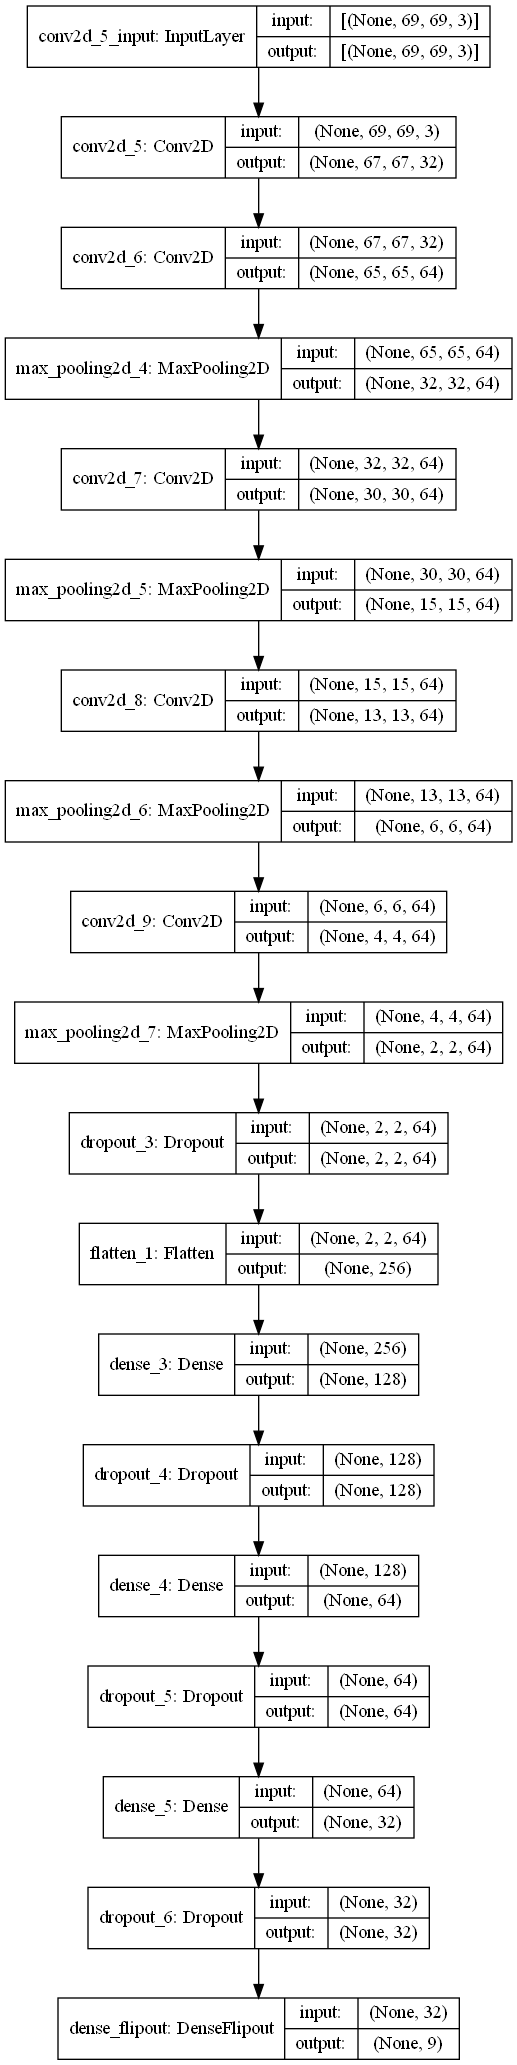

In [9]:
tf.keras.utils.plot_model(bayesian_model_scratch, to_file="bayesian.png", show_shapes=True)

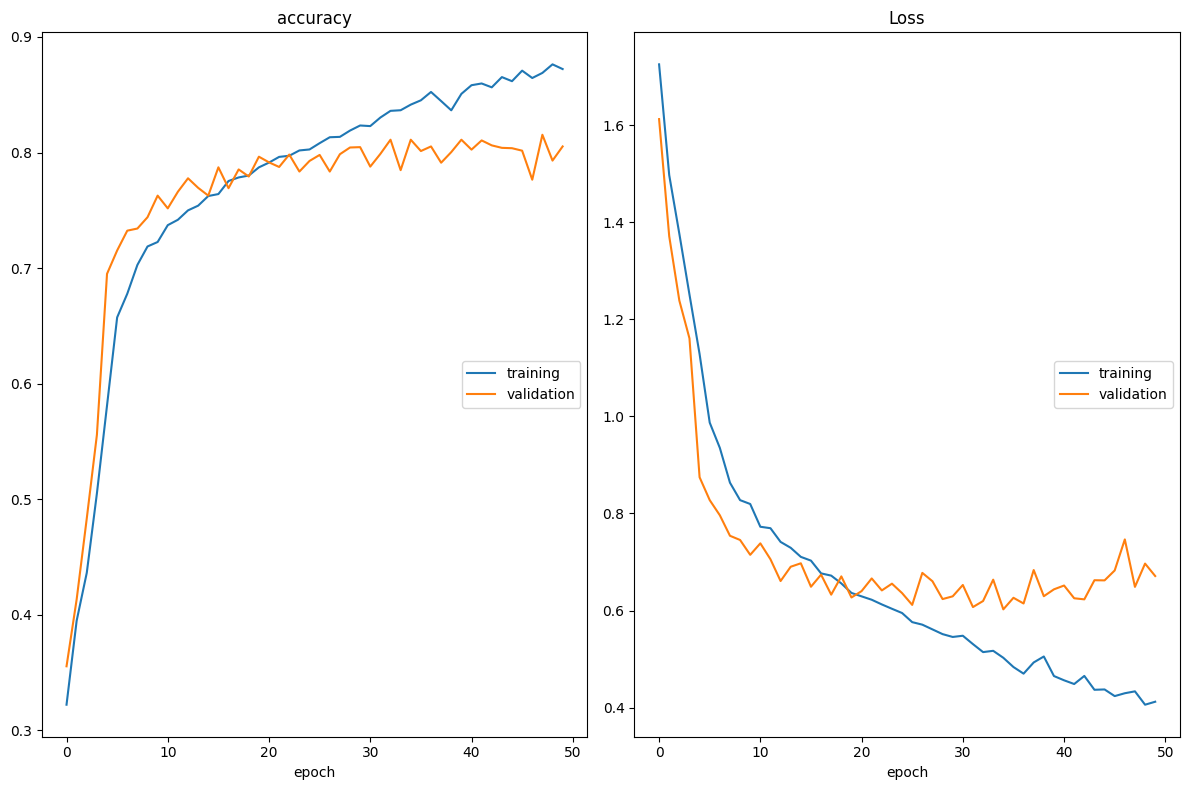

accuracy
	training         	 (min:    0.322, max:    0.876, cur:    0.872)
	validation       	 (min:    0.355, max:    0.815, cur:    0.805)
Loss
	training         	 (min:    0.406, max:    1.725, cur:    0.412)
	validation       	 (min:    0.602, max:    1.612, cur:    0.671)


In [12]:
ckpt_bayes = tf.keras.callbacks.ModelCheckpoint(
    weights_dir['bayesian'],
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    save_freq='epoch'
)
bayesian_model_scratch.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
bayesian_model_scratch.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[ckpt_bayes, PlotLossesKeras()]
)

## Classification report : Frequentist vs Bayesian CNN(without rejection criteria)

In [8]:
frequentist_model.load_weights('./checkpoints/freq_logs/best')
bayesian_model_scratch.load_weights('./checkpoints/baye_logs/best')

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
y_pred_standard = frequentist_model.predict(X_test)
y_pred_bayesian_scratch = bayesian_model_scratch.predict(X_test)

print(classification_report(y_test.argmax(axis=1), y_pred_standard.argmax(axis=1)))
print(classification_report(y_test.argmax(axis=1), y_pred_bayesian_scratch.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.63      0.63      0.63       510
           1       0.89      0.96      0.93      1037
           2       0.88      0.90      0.89       948
           3       0.75      0.34      0.47        61
           4       0.79      0.91      0.84       240
           5       0.81      0.76      0.78        94
           6       0.68      0.59      0.63       164
           7       0.58      0.46      0.51       120
           8       0.79      0.41      0.54        91

    accuracy                           0.82      3265
   macro avg       0.76      0.66      0.69      3265
weighted avg       0.81      0.82      0.81      3265

              precision    recall  f1-score   support

           0       0.62      0.62      0.62       510
           1       0.90      0.95      0.92      1037
           2       0.88      0.91      0.89       948
           3       0.60      0.34      0.44        61
           4       0.82 

## Classification report : Bayesian CNN(with ensembling + rejection criteria)

We make 100 predictions for each sample of the test set and calculate the mean probability of each class. If the mean probability is greater than a threshold, we classify the sample as the class with the highest mean probability. If the mean probability is less than the threshold, we reject the sample.

In [11]:
#Use the bayesian network to make an ensemble of 10 predictions for every sample and then decide whether to classify it ot not based on the uncertainty of the prediction
print('For 0.75:')
classified_samples, report = get_ensembled_classification_report(
    X_test, 
    y_test, 
    100, 
    bayesian_model_scratch, 
    0.75
)
print("Percentage of samples classified: ", classified_samples)
print(report)

print('For 0.80:')
classified_samples, report = get_ensembled_classification_report(
    X_test, 
    y_test, 
    100, 
    bayesian_model_scratch, 
    0.80
)
print("Percentage of samples classified: ", classified_samples)
print(report)

print('For 0.85:')
classified_samples, report = get_ensembled_classification_report(
    X_test, 
    y_test, 
    100, 
    bayesian_model_scratch, 
    0.85
)
print("Percentage of samples classified: ", classified_samples)
print(report)

print('For 0.90:')
classified_samples, report = get_ensembled_classification_report(
    X_test, 
    y_test, 
    100, 
    bayesian_model_scratch, 
    0.90
)
print("Percentage of samples classified: ", classified_samples)
print(report)

print('For 0.95:')
classified_samples, report = get_ensembled_classification_report(
    X_test,
    y_test,
    100,
    bayesian_model_scratch,
    0.95
)
print("Percentage of samples classified: ", classified_samples)
print(report)

For 0.75:


c:\Users\abhim\anaconda3\envs\sdss\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\abhim\anaconda3\envs\sdss\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\abhim\anaconda3\envs\sdss\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Percentage of samples classified:  81.37825421133232
              precision    recall  f1-score   support

           0       0.70      0.69      0.70       341
           1       0.93      0.97      0.95       974
           2       0.92      0.95      0.93       853
           3       0.00      0.00      0.00        19
           4       0.86      0.95      0.90       209
           5       0.86      0.84      0.85        79
           6       0.82      0.61      0.70        84
           7       0.81      0.32      0.46        53
           8       0.93      0.62      0.75        45

    accuracy                           0.88      2657
   macro avg       0.76      0.66      0.69      2657
weighted avg       0.88      0.88      0.88      2657

For 0.80:


c:\Users\abhim\anaconda3\envs\sdss\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\abhim\anaconda3\envs\sdss\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\abhim\anaconda3\envs\sdss\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Percentage of samples classified:  77.15160796324655
              precision    recall  f1-score   support

           0       0.72      0.71      0.72       306
           1       0.93      0.98      0.96       947
           2       0.93      0.95      0.94       834
           3       0.00      0.00      0.00        18
           4       0.87      0.95      0.91       203
           5       0.86      0.85      0.85        71
           6       0.86      0.58      0.69        66
           7       0.82      0.24      0.38        37
           8       0.92      0.62      0.74        37

    accuracy                           0.90      2519
   macro avg       0.77      0.65      0.69      2519
weighted avg       0.89      0.90      0.89      2519

For 0.85:


c:\Users\abhim\anaconda3\envs\sdss\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\abhim\anaconda3\envs\sdss\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\abhim\anaconda3\envs\sdss\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Percentage of samples classified:  71.85298621745788
              precision    recall  f1-score   support

           0       0.75      0.72      0.73       268
           1       0.94      0.98      0.96       906
           2       0.94      0.96      0.95       794
           3       0.00      0.00      0.00        15
           4       0.88      0.95      0.92       187
           5       0.87      0.85      0.86        65
           6       0.91      0.54      0.67        54
           7       0.75      0.22      0.34        27
           8       0.95      0.60      0.73        30

    accuracy                           0.91      2346
   macro avg       0.78      0.65      0.69      2346
weighted avg       0.90      0.91      0.90      2346

For 0.90:


c:\Users\abhim\anaconda3\envs\sdss\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\abhim\anaconda3\envs\sdss\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\abhim\anaconda3\envs\sdss\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Percentage of samples classified:  65.3292496171516
              precision    recall  f1-score   support

           0       0.77      0.73      0.75       218
           1       0.95      0.99      0.97       855
           2       0.95      0.96      0.96       753
           3       0.00      0.00      0.00        10
           4       0.90      0.96      0.93       170
           5       0.90      0.85      0.88        54
           6       1.00      0.59      0.74        34
           7       1.00      0.12      0.21        17
           8       0.92      0.55      0.69        22

    accuracy                           0.93      2133
   macro avg       0.82      0.64      0.68      2133
weighted avg       0.92      0.93      0.92      2133

For 0.95:
Percentage of samples classified:  55.71209800918836
              precision    recall  f1-score   support

           0       0.85      0.75      0.80       162
           1       0.96      0.99      0.97       767
           2     

c:\Users\abhim\anaconda3\envs\sdss\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\abhim\anaconda3\envs\sdss\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\abhim\anaconda3\envs\sdss\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Next, we perform an entropy based rejection. We calculate the mean entropy of the 100 predictions for each sample and reject the sample if the entropy is greater than a threshold.

In [11]:
print('For 0.65:')
classified_samples, report = get_ensembled_entropy_report(
    X_test, 
    y_test, 
    100, 
    bayesian_model_scratch, 
    0.65
)
print("Percentage of samples classified: ", classified_samples)
print(report)

print('For 0.75:')
classified_samples, report = get_ensembled_entropy_report(
    X_test, 
    y_test, 
    100, 
    bayesian_model_scratch, 
    0.75
)
print("Percentage of samples classified: ", classified_samples)
print(report)

print('For 0.85:')
classified_samples, report = get_ensembled_entropy_report(
    X_test,
    y_test,
    100,
    bayesian_model_scratch,
    0.85
)
print("Percentage of samples classified: ", classified_samples)
print(report)

print('For 0.95:')
classified_samples, report = get_ensembled_entropy_report(
    X_test,
    y_test,
    100,
    bayesian_model_scratch,
    0.95
)
print("Percentage of samples classified: ", classified_samples)
print(report)

For 0.65:


c:\Users\abhim\bayesian_sdss\utils.py:115: RuntimeWarning: divide by zero encountered in log2
c:\Users\abhim\bayesian_sdss\utils.py:115: RuntimeWarning: invalid value encountered in multiply
c:\Users\abhim\anaconda3\envs\sdss\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\abhim\anaconda3\envs\sdss\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\abhim\anaconda3\envs\sdss\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

Percentage of samples classified:  67.28943338437978
              precision    recall  f1-score   support

           0       0.76      0.70      0.73       235
           1       0.94      0.98      0.96       830
           2       0.94      0.96      0.95       789
           3       0.00      0.00      0.00        13
           4       0.89      0.96      0.92       182
           5       0.90      0.85      0.88        62
           6       0.96      0.56      0.71        43
           7       1.00      0.12      0.21        17
           8       0.94      0.58      0.71        26

    accuracy                           0.91      2197
   macro avg       0.81      0.63      0.67      2197
weighted avg       0.91      0.91      0.91      2197

For 0.75:


c:\Users\abhim\bayesian_sdss\utils.py:115: RuntimeWarning: divide by zero encountered in log2
c:\Users\abhim\bayesian_sdss\utils.py:115: RuntimeWarning: invalid value encountered in multiply
c:\Users\abhim\anaconda3\envs\sdss\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\abhim\anaconda3\envs\sdss\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\abhim\anaconda3\envs\sdss\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

Percentage of samples classified:  71.08728943338438
              precision    recall  f1-score   support

           0       0.75      0.68      0.71       264
           1       0.93      0.98      0.96       858
           2       0.93      0.96      0.94       822
           3       0.00      0.00      0.00        15
           4       0.89      0.95      0.92       189
           5       0.88      0.86      0.87        65
           6       0.88      0.57      0.69        53
           7       0.88      0.27      0.41        26
           8       0.95      0.62      0.75        29

    accuracy                           0.91      2321
   macro avg       0.79      0.65      0.69      2321
weighted avg       0.90      0.91      0.90      2321

For 0.85:


c:\Users\abhim\bayesian_sdss\utils.py:115: RuntimeWarning: divide by zero encountered in log2
c:\Users\abhim\bayesian_sdss\utils.py:115: RuntimeWarning: invalid value encountered in multiply
c:\Users\abhim\anaconda3\envs\sdss\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\abhim\anaconda3\envs\sdss\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\abhim\anaconda3\envs\sdss\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

Percentage of samples classified:  73.87442572741195
              precision    recall  f1-score   support

           0       0.75      0.67      0.71       292
           1       0.92      0.98      0.95       880
           2       0.93      0.96      0.94       839
           3       0.00      0.00      0.00        17
           4       0.87      0.95      0.91       195
           5       0.86      0.83      0.84        69
           6       0.86      0.60      0.71        60
           7       0.78      0.24      0.37        29
           8       0.95      0.61      0.75        31

    accuracy                           0.90      2412
   macro avg       0.77      0.65      0.69      2412
weighted avg       0.89      0.90      0.89      2412

For 0.95:


c:\Users\abhim\bayesian_sdss\utils.py:115: RuntimeWarning: divide by zero encountered in log2
c:\Users\abhim\bayesian_sdss\utils.py:115: RuntimeWarning: invalid value encountered in multiply


Percentage of samples classified:  77.24349157733538
              precision    recall  f1-score   support

           0       0.73      0.67      0.70       320
           1       0.92      0.98      0.94       898
           2       0.92      0.95      0.93       864
           3       0.00      0.00      0.00        19
           4       0.86      0.95      0.91       202
           5       0.86      0.84      0.85        73
           6       0.83      0.61      0.70        71
           7       0.80      0.22      0.34        37
           8       0.93      0.66      0.77        38

    accuracy                           0.89      2522
   macro avg       0.76      0.65      0.68      2522
weighted avg       0.88      0.89      0.88      2522



c:\Users\abhim\anaconda3\envs\sdss\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\abhim\anaconda3\envs\sdss\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\abhim\anaconda3\envs\sdss\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Bayesian Model:


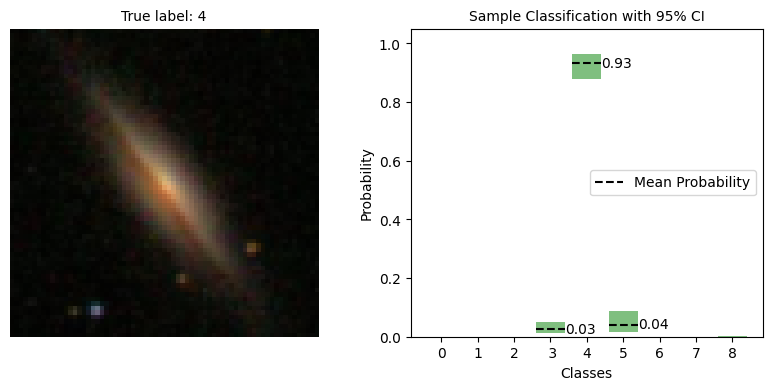

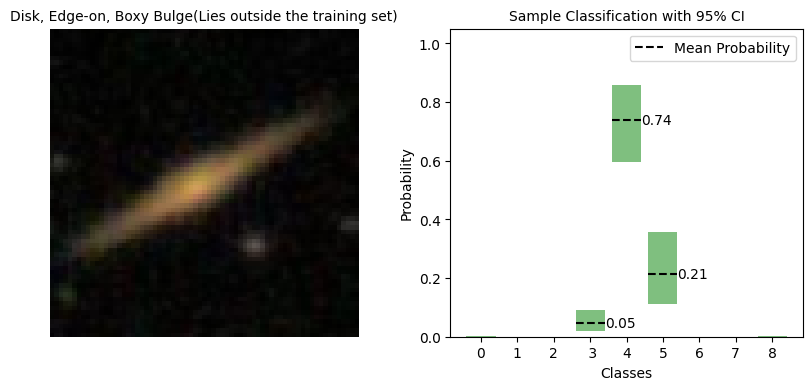

Frequentist Model:


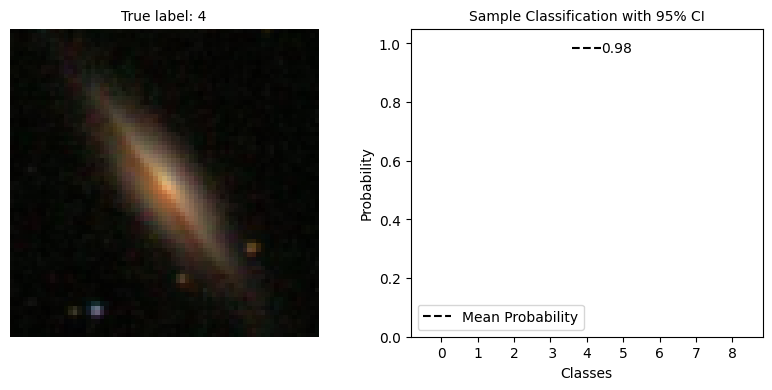

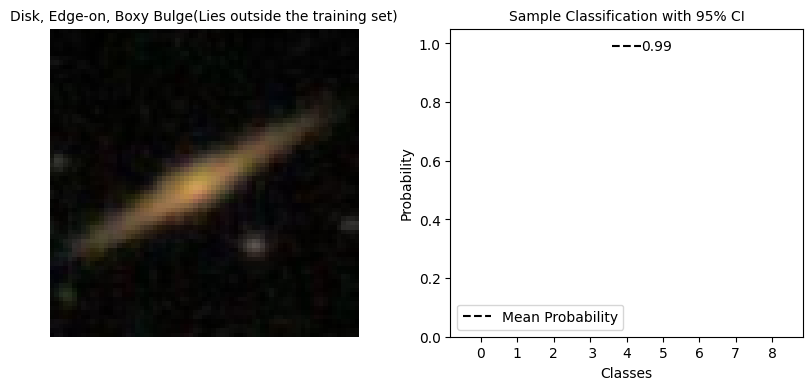

In [12]:
print('Bayesian Model:')
plot_sample_with_confidence(0, X_test, y_test, ensemble_size, style='bar', model = bayesian_model_scratch)
plot_sample_with_confidence(0, images_removed, labels_removed, ensemble_size, 
                            mode='removed', style = 'bar', model = bayesian_model_scratch)
print('Frequentist Model:')
plot_sample_with_confidence(0, X_test, y_test, ensemble_size, style='bar', model = frequentist_model)
plot_sample_with_confidence(0, images_removed, labels_removed, ensemble_size, 
                            mode='removed', style = 'bar', model = frequentist_model)